In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

make_hwp_solutions.py runs like:\
python3 make_hwp_solutions.py context.yaml hwp_context.yaml --obs-id obs_ufm_mv7_1705889952

In [2]:
obs_id = []
with h5py.File("/so/home/jsugiyama/DailyAnalysis/satp1_HWPangle/hwp_angle.h5", 'r') as f:
    for key in f.keys():
        obs_id.append(key)
obs_id

['obs_ufm_mv7_1705889952']

Read the HWP encoder data 

In [4]:
with h5py.File("/so/home/jsugiyama/DailyAnalysis/satp1_HWPangle/hwp_angle.h5", 'r') as f:
    hwp_angle_data = f[obs_id[0]]
    print(hwp_angle_data.keys())
    angle_v_1=np.array(hwp_angle_data["version"])[10]
    angle_v_2=np.array(hwp_angle_data["version_2"])[10]
    print(f"Enc1 angle version:{angle_v_1}")
    print(f"Enc2 angle version:{angle_v_2}")

<KeysViewHDF5 ['hwp_angle', 'hwp_angle_2', 'hwp_angle_ver1', 'hwp_angle_ver1_2', 'hwp_angle_ver2', 'hwp_angle_ver2_2', 'hwp_rate', 'hwp_rate_2', 'locked', 'locked_2', 'stable', 'stable_2', 'timestamps', 'version', 'version_2']>
Enc1 angle version:3
Enc2 angle version:3


## Integrate the angle data to detector data

In [9]:
import sotodlib
from sotodlib import core
from sotodlib.io import load_smurf as ls
from sotodlib.io.load_smurf import Observations, Files, TuneSets, Tunes
from sotodlib.io.g3thk_db import G3tHk, HKFiles, HKAgents, HKFields, logger
from sotodlib.hwp import g3thwp
from sotodlib.tod_ops.fft_ops import calc_psd, calc_wn

from sotodlib.io import g3tsmurf_utils
from sodetlib.operations.iv import IVAnalysis
from sotodlib.io.g3thk_db import G3tHk, HKFiles, HKAgents, HKFields, logger
from sotodlib.io import hk_utils
from sotodlib.io.load_smurf import load_file

/so/shared-software/so-unstable-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
archive_path='/so/level2-daq/satp1/timestreams/'
db_path='/so/level2-daq/databases/satp1/g3tsmurf.db'
meta_path='/so/level2-daq/satp1/smurf/'
hk_db_path='/so/level2-daq/databases/satp1/g3hk.db'

SMURF = ls.G3tSmurf(archive_path=archive_path, db_path=db_path, meta_path=meta_path, hk_db_path=hk_db_path)
session = SMURF.Session()

obs_all = session.query(Observations)
obs = obs_all.filter(Observations.obs_id == obs_id[0]).one()
fs = [f.name for f in obs.files]
print(fs)
aman = ls.load_file(fs, archive=SMURF)

['/so/level2-daq/satp1/timestreams/17058/ufm_mv7/1705889952_000.g3', '/so/level2-daq/satp1/timestreams/17058/ufm_mv7/1705889952_001.g3', '/so/level2-daq/satp1/timestreams/17058/ufm_mv7/1705889952_002.g3']


100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


In [11]:
with h5py.File("/so/home/jsugiyama/DailyAnalysis/satp1_HWPangle/hwp_angle.h5", 'r') as f:
    hwp_aman = f[obs_id[0]]
    hwp_angle = np.array(hwp_aman['hwp_angle'])
aman.wrap_new('hwp_angle', dtype='float32', shape=('samps', ))
aman.hwp_angle = hwp_angle

Text(0.5, 0, 'Timestamps')

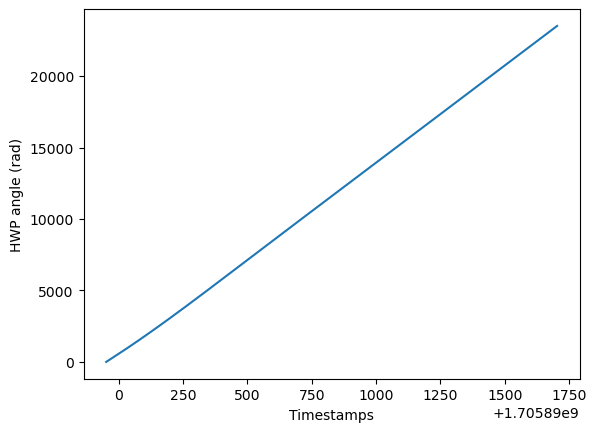

In [14]:
plt.figure()
plt.plot(aman.timestamps, np.unwrap(aman.hwp_angle))
plt.ylabel('HWP angle (rad)')
plt.xlabel('Timestamps')